In [1]:
import dgl
import math
import torch
import numpy as np
from os import path
from pathlib import Path
from dgl.data import DGLDataset
from ToyDGLDataset import ToyDGLDataset, GetNodeFeatureVectors, GetEdgeFeatureVectors, GetNeighborNodes, GetEdgeList

Using backend: pytorch


In [2]:
datasetName = 'ToyDataset01'
datasetDir = path.join('/home/andrew/GNN_Sandbox/GraphDatasets', datasetName)
dataset = ToyDGLDataset(datasetName, datasetDir)

Done loading data from cached files.


In [3]:
dataset.printProperties()

Num Graph classes: 2
Graph classes: [0, 1]
Number of graphs: 4000
Number of all nodes in all graphs: 187464
Number of all edges in all graphs: 10140816
Dim node features: 5
Node feature keys: ['P_t', 'Eta', 'Phi', 'Mass', 'Type']
Dim edge features: 3
Edge feature keys: ['DeltaEta', 'DeltaPhi', 'RapiditySquared']


In [4]:
graph, label = dataset[0]
print(graph)
print(f'Label: {label}')
print(GetNodeFeatureVectors(graph))

Graph(num_nodes=14, num_edges=182,
      ndata_schemes={'feat': Scheme(shape=(5,), dtype=torch.float64)}
      edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.float64)})
Label: 0
tensor([[ 8.2500e+01,  2.4013e+00,  4.4686e+00,  6.9914e-01,  1.0000e+00],
        [ 3.3428e+01,  6.1951e+00,  4.7875e+00,  2.0964e-01,  0.0000e+00],
        [ 8.8582e+01, -4.9841e+00,  5.8098e+00,  4.0086e-01,  2.0000e+00],
        [ 9.1063e+01, -1.9321e+00,  1.6134e+00,  4.3644e-01,  0.0000e+00],
        [ 8.3695e+01,  8.4926e+00,  5.9178e+00,  9.9072e-01,  1.0000e+00],
        [ 8.3720e+01, -5.7298e+00,  3.1423e+00,  5.3718e-01,  2.0000e+00],
        [ 4.0792e+01, -6.3605e+00,  4.7412e+00,  7.0650e-01,  1.0000e+00],
        [ 1.6013e+01, -9.9891e+00,  4.0879e+00,  9.9766e-01,  1.0000e+00],
        [ 8.3934e+01,  5.7967e+00,  5.4796e+00,  6.5208e-01,  1.0000e+00],
        [ 1.1577e+01,  7.7988e+00,  1.1120e+00,  4.8540e-01,  0.0000e+00],
        [ 7.7765e+01,  2.9263e+00,  4.8746e+00,  7.1705e-01,  1.0

In [5]:
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler

splitIndices = dataset.get_split_indices()

train_sampler = SubsetRandomSampler(splitIndices['train'])
val_sampler = SubsetRandomSampler(splitIndices['valid'])
test_sampler = SubsetRandomSampler(splitIndices['test'])


train_dataloader = GraphDataLoader(dataset, sampler=train_sampler, batch_size=32, drop_last=False)
val_dataloader = GraphDataLoader(dataset, sampler=val_sampler, batch_size=32, drop_last=False)
test_dataloader = GraphDataLoader(dataset, sampler=test_sampler, batch_size=32, drop_last=False)

In [6]:
it = iter(train_dataloader)
batch = next(it)
print(batch)

[Graph(num_nodes=1395, num_edges=65818,
      ndata_schemes={'feat': Scheme(shape=(5,), dtype=torch.float64)}
      edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.float64)}), tensor([0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 1, 0, 0])]


In [7]:
batched_graph, labels = batch
print('Number of nodes for each graph element in the batch:', batched_graph.batch_num_nodes())
print('Number of edges for each graph element in the batch:', batched_graph.batch_num_edges())
print(labels)
# Recover the original graph elements from the minibatch
graphs = dgl.unbatch(batched_graph)
print('The original graphs in the minibatch:')
print(graphs)

Number of nodes for each graph element in the batch: tensor([23, 42, 51, 38, 38, 21, 69, 48, 63, 54, 58, 50, 27, 28, 57, 30, 42, 61,
        59, 70, 42, 27, 70, 42, 33, 25, 35, 39, 38, 49, 35, 31])
Number of edges for each graph element in the batch: tensor([ 506, 1722, 2550, 1406, 1406,  420, 4692, 2256, 3906, 2862, 3306, 2450,
         702,  756, 3192,  870, 1722, 3660, 3422, 4830, 1722,  702, 4830, 1722,
        1056,  600, 1190, 1482, 1406, 2352, 1190,  930])
tensor([0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 1, 0, 0])
The original graphs in the minibatch:
[Graph(num_nodes=23, num_edges=506,
      ndata_schemes={'feat': Scheme(shape=(5,), dtype=torch.float64)}
      edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.float64)}), Graph(num_nodes=42, num_edges=1722,
      ndata_schemes={'feat': Scheme(shape=(5,), dtype=torch.float64)}
      edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.float64)}), Graph(num_nodes=51, num_e

In [8]:
from dgl.nn import GraphConv
import torch.nn as nn
import torch.nn.functional as F

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)
        
    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        g.ndata['h'] = h
        return dgl.mean_nodes(g, 'h')

In [9]:
# The evaluation function
def eval(model, device, dataloader):
    model = model.to(device)
    model.eval()
    y_true = []
    y_logits = []

    for batched_graph, labels in dataloader:
        batched_graph = batched_graph.to(device)
        labels = labels.to(device)
        nodeFeatVec = GetNodeFeatureVectors(batched_graph)

        with torch.no_grad():
            pred = model(batched_graph, nodeFeatVec)

        y_true.append(labels.detach().cpu())
        y_logits.append(pred.detach().cpu())

    y_true = torch.cat(y_true, dim = 0).numpy()
    y_logits = torch.cat(y_logits, dim = 0).numpy()
    y_pred = y_logits.argmax(1)
    
    num_correct_pred = (y_pred == y_true).sum().item()
    num_total_pred = len(y_true)
    acc =  num_correct_pred / num_total_pred
    
    evalDict = {"y_true": y_true, "y_logits": y_logits, "y_pred": y_pred, "acc": acc}

    return evalDict

In [10]:
import copy
from TrainResults import TrainResults

def train(model, device, dataloader, optimizer, loss_fn, epochs):
    print(f'Device: {device}')
    model = model.to(device)
    model.train()
    
    results = TrainResults()

    for epoch in range(epochs):
        for batched_graph, labels in dataloader:
            batched_graph = batched_graph.to(device)
            labels = labels.to(device)
            nodeFeatVec = GetNodeFeatureVectors(batched_graph)

            #forward
            pred =  model(batched_graph, nodeFeatVec)

            # compute loss
            loss = loss_fn(pred, labels)

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_result = eval(model, device, train_dataloader)
        val_result = eval(model, device, val_dataloader)
        test_result = eval(model, device, test_dataloader)
        results.addResult(model, loss.detach().cpu().numpy(), train_result['acc'], val_result['acc'], test_result['acc'])
        results.printLastResult()
        
    return results

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create the model with given dimensions
model = GCN(dataset.dim_nfeats, 16, dataset.num_graph_classes).to(device)
model.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()
epochs = 50

result = train(model, device, train_dataloader, optimizer, loss_fn, epochs)


Device: cuda
Epoch: 00, Loss: 0.5313, Train: 79.54%, Valid: 79.12% Test: 77.25%
Epoch: 01, Loss: 0.3304, Train: 88.88%, Valid: 87.50% Test: 88.88%
Epoch: 02, Loss: 0.3271, Train: 93.67%, Valid: 93.75% Test: 93.88%
Epoch: 03, Loss: 0.2359, Train: 93.08%, Valid: 93.12% Test: 91.12%
Epoch: 04, Loss: 0.3361, Train: 95.25%, Valid: 95.00% Test: 95.12%
Epoch: 05, Loss: 0.1040, Train: 92.71%, Valid: 92.38% Test: 93.00%
Epoch: 06, Loss: 0.1758, Train: 95.12%, Valid: 95.00% Test: 95.25%
Epoch: 07, Loss: 0.1212, Train: 93.00%, Valid: 92.88% Test: 94.00%
Epoch: 08, Loss: 0.1594, Train: 95.75%, Valid: 95.75% Test: 96.00%
Epoch: 09, Loss: 0.0740, Train: 95.71%, Valid: 95.50% Test: 96.00%
Epoch: 10, Loss: 0.0973, Train: 90.83%, Valid: 89.88% Test: 92.00%
Epoch: 11, Loss: 0.2715, Train: 96.12%, Valid: 96.00% Test: 95.50%
Epoch: 12, Loss: 0.1356, Train: 96.33%, Valid: 96.12% Test: 95.75%
Epoch: 13, Loss: 0.1208, Train: 95.75%, Valid: 95.62% Test: 95.88%
Epoch: 14, Loss: 0.1271, Train: 95.96%, Valid: 95

Epoch: 49, Loss: 0.0618, Train: 97.79%, Valid: 98.38% Test: 97.12%


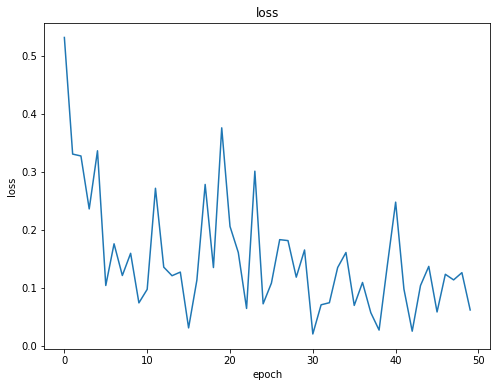

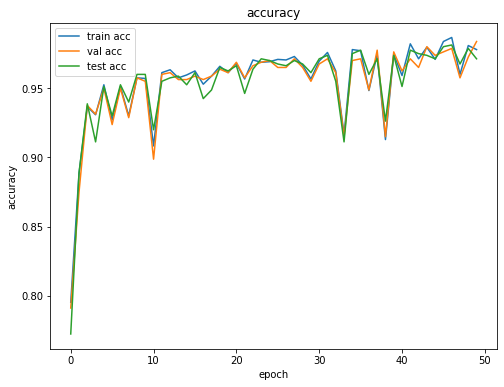

In [12]:
result.printBestResult()
result.plotLoss()
result.plotAcc()

In [13]:
print(graph.nodes[[0,1]])
print(graph.nodes[0])
print(graph.nodes[1])
print(graph.nodes[10])
print(graph.nodes[3])

NodeSpace(data={'feat': tensor([[82.4999,  2.4013,  4.4686,  0.6991,  1.0000],
        [33.4276,  6.1951,  4.7875,  0.2096,  0.0000]], dtype=torch.float64)})
NodeSpace(data={'feat': tensor([[82.4999,  2.4013,  4.4686,  0.6991,  1.0000]], dtype=torch.float64)})
NodeSpace(data={'feat': tensor([[33.4276,  6.1951,  4.7875,  0.2096,  0.0000]], dtype=torch.float64)})
NodeSpace(data={'feat': tensor([[77.7649,  2.9263,  4.8746,  0.7170,  1.0000]], dtype=torch.float64)})
NodeSpace(data={'feat': tensor([[91.0627, -1.9321,  1.6134,  0.4364,  0.0000]], dtype=torch.float64)})


In [14]:
#print(graph.out_edges(7))
#print(graph.edges[(0,1)]) # src, dst
#print(graph.edges[0,1]) # src, dst
print(graph.edges[[0, 0], [1,2]]) # src, dst
print(graph.edges[[10], [3]])
print(graph.edges[[3], [10]])
print(graph.edges[0])
print(graph.edges[1])
#print(graph.edges[0]) # eid

EdgeSpace(data={'feat': tensor([[ 3.7938,  0.3189, 14.4946],
        [ 7.3855,  1.3411, 56.3441]], dtype=torch.float64)})
EdgeSpace(data={'feat': tensor([[ 4.8584,  3.2611, 34.2393]], dtype=torch.float64)})
EdgeSpace(data={'feat': tensor([[ 4.8584,  3.2611, 34.2393]], dtype=torch.float64)})
EdgeSpace(data={'feat': tensor([[ 3.7938,  0.3189, 14.4946]], dtype=torch.float64)})
EdgeSpace(data={'feat': tensor([[ 7.3855,  1.3411, 56.3441]], dtype=torch.float64)})


In [15]:
edgeList = GetNeighborNodes(graph, 0)
nodeFeat = graph.ndata['feat']
print(graph.nodes[0])
print(nodeFeat)
print(edgeList)


NodeSpace(data={'feat': tensor([[82.4999,  2.4013,  4.4686,  0.6991,  1.0000]], dtype=torch.float64)})
tensor([[ 8.2500e+01,  2.4013e+00,  4.4686e+00,  6.9914e-01,  1.0000e+00],
        [ 3.3428e+01,  6.1951e+00,  4.7875e+00,  2.0964e-01,  0.0000e+00],
        [ 8.8582e+01, -4.9841e+00,  5.8098e+00,  4.0086e-01,  2.0000e+00],
        [ 9.1063e+01, -1.9321e+00,  1.6134e+00,  4.3644e-01,  0.0000e+00],
        [ 8.3695e+01,  8.4926e+00,  5.9178e+00,  9.9072e-01,  1.0000e+00],
        [ 8.3720e+01, -5.7298e+00,  3.1423e+00,  5.3718e-01,  2.0000e+00],
        [ 4.0792e+01, -6.3605e+00,  4.7412e+00,  7.0650e-01,  1.0000e+00],
        [ 1.6013e+01, -9.9891e+00,  4.0879e+00,  9.9766e-01,  1.0000e+00],
        [ 8.3934e+01,  5.7967e+00,  5.4796e+00,  6.5208e-01,  1.0000e+00],
        [ 1.1577e+01,  7.7988e+00,  1.1120e+00,  4.8540e-01,  0.0000e+00],
        [ 7.7765e+01,  2.9263e+00,  4.8746e+00,  7.1705e-01,  1.0000e+00],
        [ 7.7500e+01,  4.9447e-01,  3.2061e+00,  4.0157e-01,  0.0000e+00

In [16]:
def ConcatNodeAndEdgeFeatures(graph, nodeFeat, nodeLabel: int):
    neighbors = GetNeighborNodes(graph, nodeLabel)
    nfeat = nodeFeat[nodeLabel]
    efeat = torch.reshape(graph.edges[neighbors].data['feat'], (-1,))
    #print(nfeat)
    #print(efeat)
    return torch.cat((nfeat, efeat))
    
x = ConcatNodeAndEdgeFeatures(graph, nodeFeat, 0)
print(x)

edgeFeatureVec = GetEdgeFeatureVectors(graph)

x = (1,2,3)
print(x)


tensor([ 82.4999,   2.4013,   4.4686,   0.6991,   1.0000,   3.7938,   0.3189,
         14.4946,   7.3855,   1.3411,  56.3441,   4.3334,   2.8552,  26.9309,
          6.0913,   1.4491,  39.2035,   8.1311,   1.3263,  67.8747,   8.7619,
          0.2726,  76.8443,  12.3904,   0.3807, 153.6669,   3.3954,   1.0109,
         12.5504,   5.3975,   3.3566,  40.3997,   0.5250,   0.4059,   0.4404,
          1.9069,   1.2625,   5.2301,  10.9706,   2.7195, 127.7507,   5.1435,
          0.1850,  26.4903], dtype=torch.float64)
(1, 2, 3)
